# **Analysis of Yelp Reviews - Exploratory Data Analysis**

# Contents



*   Introduction
*   Importing Data From github
*   Cleaning Data








# Introduction
The goal for this project is to use Natural Language Processing to interpret and collect review data from Yelp. Once we have this data we can analyze it and determine the sentiment of any location based on the text of their reviews.





In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **1. Data Loading**

In [8]:
#here we are importing the yelp business dataset
yelp_bus_df = pd.read_csv('https://media.githubusercontent.com/media/rabin1323/DataScience_Final_Project/main/yelp_business_Data.csv',nrows=90000)
yelp_bus_df

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,jV5dMarm1r-gVzQ6SwNjrw,"""Mediterra Restaurant & Lounge""",Financial District,"""133 Richmond Street West""",Toronto,ON,M5H 2L3,43.650443,-79.384832,1.5,3,0,Restaurants;Seafood
89996,EK3bsv-dFDGnmdQLoHl3SA,"""Arizona Tree and Turf Equipment""",NaN,"""1502 W Bell Rd""",Phoenix,AZ,85023,33.640987,-112.092058,5.0,3,1,Shopping;Landscaping;Local Services;Tree Servi...
89997,tFUWLG4yHqdtM90BubRm0g,"""Whirlwind Golf Club""",NaN,"""5692 W North Loop Rd""",Chandler,AZ,85226,33.269677,-111.990401,4.0,27,1,Golf;Active Life
89998,tg1Y3RZfUcK8_GHYhLLxgw,"""Rocket Man BBQ & Catering""",Southeast,"""2550 Chandler Ave, Ste 34""",Las Vegas,NV,89120,36.074459,-115.113965,5.0,3,1,American (Traditional);Barbeque;Event Planning...


We want to focus only on restaurants and will only keep open restaurants for our analysis

In [9]:

restaurants = yelp_bus_df[yelp_bus_df['categories'].str.contains("Restaurants")]

open_restaurants = restaurants[restaurants['is_open']==1].reset_index(drop = True)

open_restaurants.groupby(['city']).agg({'review_count':'sum', 
                         'business_id':'size'}).sort_values(by = 'review_count', ascending = False).head(5)

,review_count,business_id
city,,
Las Vegas,396080,2041
Phoenix,140846,1314
Toronto,134002,2580
Scottsdale,74288,445
Charlotte,71072,992


Since Las Vegas has the highest number of restaurant reviews we decided to only focus on this specific location

In [10]:
restaurants_in_Vegas = open_restaurants[open_restaurants['city'] == 'Las Vegas'].reset_index(drop = True)

**Average number of reviews per restaurant** 

In [11]:
restaurants_in_Vegas['review_count'].mean()

194.06173444390004

**Sample 1000 restaurants**

In [12]:
random.seed(100)
sampled_restaurants = random.sample(list(restaurants_in_Vegas['business_id']), 500)
selected_restaurants_in_Vegas = restaurants_in_Vegas[restaurants_in_Vegas['business_id'].isin(sampled_restaurants)].reset_index(drop = True)
selected_restaurants_in_Vegas.shape[0]

500

**Projected count of reviews**

In [13]:
restaurants_in_Vegas['review_count'].sum()

396080

**Now we will import the Reviews DataSet from github**

In [15]:
yelp_reviews_df = pd.read_csv('https://media.githubusercontent.com/media/rabin1323/DataScience_Final_Project/main/yelp_review_Data.csv', nrows=90000)
print('Columns in review data', yelp_reviews_df.columns)


Columns in review data Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')


**Merge review and business data**

In [16]:
cols_to_keep = ['business_id', 'name', 'city', 'state', 'postal_code','latitude', 'longitude']
Vegas_restaurants_reviews = pd.merge(selected_restaurants_in_Vegas[cols_to_keep], yelp_reviews_df, left_on = ['business_id']\
                                     , right_on = ['business_id'], how = 'left')

**Look at distribution of reviews across different years**

In [17]:
Vegas_restaurants_reviews['date'] = pd.to_datetime(Vegas_restaurants_reviews['date'])
Vegas_restaurants_reviews['year'] = Vegas_restaurants_reviews['date'].dt.year
Vegas_restaurants_reviews['year'].value_counts()

2017.0    374
2016.0    297
2015.0    228
2014.0    172
2013.0    130
2012.0     86
2011.0     78
2010.0     56
2009.0     21
2008.0     14
2007.0      4
Name: year, dtype: int64

**Plot the distribution**

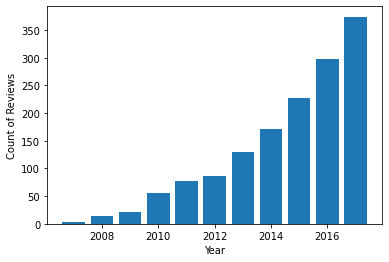

In [18]:
x = Vegas_restaurants_reviews['year'].value_counts().sort_index().index
y = Vegas_restaurants_reviews['year'].value_counts().sort_index().values
fig, ax = plt.subplots()
plt.bar(x, y)
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.show()

We decided to analyze year 2016 and 2018 because we want to focus on the most recent year data for better outcomes. Also, these two years have the maximum number of reviews.

**Filter reviews written in 2017 and 2016**

In [19]:
Vegas_restaurants_reviews_2017_2016 = Vegas_restaurants_reviews[Vegas_restaurants_reviews['year'].isin(['2017','2016'])].reset_index(drop = True)

**Look at distribution of review rating**

In [20]:
Vegas_restaurants_reviews_2017_2016['stars'].value_counts().sort_index()

1.0    102
2.0     51
3.0     58
4.0    143
5.0    317
Name: stars, dtype: int64

**Plot the distribution**

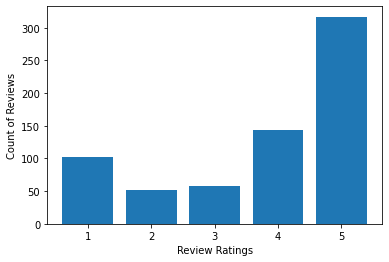

In [21]:
x = Vegas_restaurants_reviews_2017_2016['stars'].value_counts().sort_index().index
y = Vegas_restaurants_reviews_2017_2016['stars'].value_counts().sort_index().values
fig, ax = plt.subplots()
plt.bar(x, y)
plt.xlabel('Review Ratings')
plt.ylabel('Count of Reviews')
plt.show()

In [22]:
#counting the number of words in each
Vegas_restaurants_reviews_2017_2016['Review_Word_Count'] = Vegas_restaurants_reviews_2017_2016['text'].apply(lambda x: len(str(x).split()))

Text(0, 0.5, 'Number of Words')

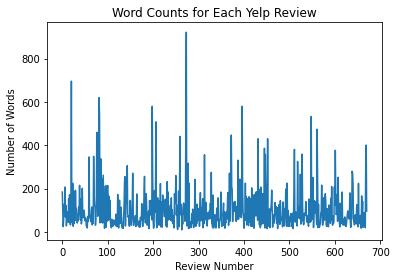

In [23]:
Vegas_restaurants_reviews_2017_2016['Review_Word_Count'].plot()
plt.title('Word Counts for Each Yelp Review')
plt.xlabel('Review Number')
plt.ylabel('Number of Words')

Looks like most reviews are under 1000 words

In [24]:
Vegas_restaurants_reviews_2017_2016['Review_Char_Count'] = Vegas_restaurants_reviews_2017_2016['text'].apply(lambda x: len(str(x)))

**Removing Stop Words**

Stop words like 'the', 'a', 'for', or 'so' don't really have much meaning for sentiment analysis. Removing them is an important step to imrprove overall efficiency and make the overall meaning of each review easier to understand with less filler.

In [25]:
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


example_sent = """This is a sample sentence,
                  showing off the stop words filtration."""

stop_words = set(stopwords.words('english'))
 
word_tokens = word_tokenize(example_sent)
 
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
 
filtered_sentence = []
 
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

print(word_tokens)
print(filtered_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['This', 'is', 'a', 'sample', 'sentence', ',', 'showing', 'off', 'the', 'stop', 'words', 'filtration', '.']
['This', 'sample', 'sentence', ',', 'showing', 'stop', 'words', 'filtration', '.']


Now we can apply this to our reviews dataset, first we're going to add some more columns to make the analysis easier, one column will be for lowercase reviews and the other will be for lowercase and no punctuation

In [26]:
Vegas_restaurants_reviews_2017_2016['text']=Vegas_restaurants_reviews_2017_2016['text'].str.replace('\d+','') 
#removing numerals

In [34]:
Vegas_restaurants_reviews_2017_2016['text']=Vegas_restaurants_reviews_2017_2016['text'].str.replace('\n',' ').str.replace('\r','')

In [35]:
Vegas_restaurants_reviews_2017_2016['Lowercase'] = Vegas_restaurants_reviews_2017_2016['text'].apply(lambda x: ' '.join(word.lower() for word in str(x).split()))

In [36]:
Vegas_restaurants_reviews_2017_2016['Cleaned'] = Vegas_restaurants_reviews_2017_2016['Lowercase'].str.replace('[^\w\s]', '')

In [37]:
Reviews_noStopWords = []

for i in range(len(Vegas_restaurants_reviews_2017_2016)):
    
    review = str(Vegas_restaurants_reviews_2017_2016['Cleaned'][i])
    review = review
    review = review.lower()
    
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    Reviews_noStopWords.append(filtered_sentence)

In [38]:
Vegas_restaurants_reviews_2017_2016['No_Stop_Words:Tokens'] = Reviews_noStopWords

In [39]:
Vegas_restaurants_reviews_2017_2016['No_Stop_Words:Sentence'] = Reviews_noStopWords
for i in range(len(Vegas_restaurants_reviews_2017_2016)): 
    text_list = Vegas_restaurants_reviews_2017_2016['No_Stop_Words:Tokens'][i]
    blank = ''
    for word in text_list:
        blank = blank+' '+word
    Vegas_restaurants_reviews_2017_2016['No_Stop_Words:Sentence'][i] = blank

Now lets see how many words from the original review are stop words

In [40]:
Stop_Word_Count = []
for i in range(len(Vegas_restaurants_reviews_2017_2016)):
    review = str(Vegas_restaurants_reviews_2017_2016['text'][i]).lower()
    count = 0
    for word in review.split():
        if word in stop_words:
            count += 1
    Stop_Word_Count.append(count)

Vegas_restaurants_reviews_2017_2016['Stop_Word_Count'] = Stop_Word_Count

Text(0, 0.5, 'Number of Words')

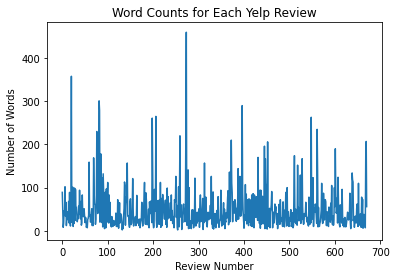

In [41]:
Vegas_restaurants_reviews_2017_2016['Stop_Word_Count'].plot()
plt.title('Word Counts for Each Yelp Review')
plt.xlabel('Review Number')
plt.ylabel('Number of Words')

Above plot looks similar to the word count plot due to that 700 word review, let's calculate the percentage of stop words instead and plot that

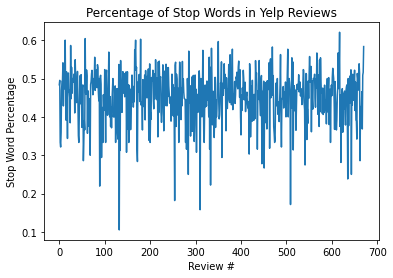

In [42]:
full = Vegas_restaurants_reviews_2017_2016['Review_Word_Count']
partial = Vegas_restaurants_reviews_2017_2016['Stop_Word_Count']

Vegas_restaurants_reviews_2017_2016['Stop_Words_%'] = partial/full
Vegas_restaurants_reviews_2017_2016['Stop_Words_%'].plot()
plt.title('Percentage of Stop Words in Yelp Reviews')
plt.xlabel('Review #')
plt.ylabel('Stop Word Percentage');

Looks like most reviews are around 50% stop words.

**Other Review Filtering Methods**

Stop words are a good first step when removing words with no meaning, but lets take a look at all our text and see if there are any words that are frequently repeated

In [45]:
pd.Series(''.join(Vegas_restaurants_reviews_2017_2016['No_Stop_Words:Sentence']).split()).value_counts()[:20]

food          487
good          397
place         390
service       283
great         279
like          238
one           229
chicken       211
time          205
back          192
get           175
go            166
really        166
got           164
order         159
would         158
vegas         152
ordered       149
us            148
restaurant    139
dtype: int64

Out of over 700 reviews, all of these words don't even appear once per review so we'll keep them in. Especially the words like 'good' and 'great': these are very important to hold onto

If a word like 'restaurant' had over 700 appearances (more than once per review on average) I would have gotten rid of it, but these shouldn't make a significant impact

**Word Clouds**

Now that we don't have stop words we can generate a word cloud that won't have any filler words - this will make the more frequently used words that have meaning stand out more as opposed to seeing only stop words

In [49]:
Vegas_restaurants_reviews_2017_2016

,business_id,name,city,state,postal_code,latitude,longitude,review_id,user_id,stars,date,text,useful,funny,cool,year,Review_Word_Count,Review_Char_Count,Lowercase,Cleaned,No_Stop_Words:Tokens,No_Stop_Words:Sentence,Stop_Word_Count,Stop_Words_%
0,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183,36.010086,-115.118656,g8yoM5RkDL2HTpk07jkYCg,oFyOUOeGTRZhFPF9uTqrTQ,5.0,2016-12-13,Went in for the first time tonight and within ...,0.0,0.0,1.0,2016.0,184,996,went in for the first time tonight and within ...,went in for the first time tonight and within ...,"[went, first, time, tonight, within, first, bi...",went first time tonight within first bite gar...,89,0.483696
1,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183,36.010086,-115.118656,2-lACtC5w76LRGXlE3c-UQ,RSLTG7N0wYJhRTW5CGEm5Q,5.0,2017-09-22,Hands down this is Las Vegas best mom and pop ...,2.0,1.0,1.0,2017.0,105,595,hands down this is las vegas best mom and pop ...,hands down this is las vegas best mom and pop ...,"[hands, las, vegas, best, mom, pop, style, ita...",hands las vegas best mom pop style italian cu...,52,0.495238
2,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183,36.010086,-115.118656,IIK7UIWsXe3iE45LzCGD3w,IKgSaGLf-CsGke5p8DY1-w,5.0,2017-10-10,The BEST & REAL ITALIAN Food in Las Vegas! So ...,0.0,0.0,0.0,2017.0,24,130,the best & real italian food in las vegas! so ...,the best real italian food in las vegas so ma...,"[best, real, italian, food, las, vegas, many, ...",best real italian food las vegas many wannabe...,8,0.333333
3,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183,36.010086,-115.118656,MKmC1puXQQse-lsztnXVFQ,ThZXe1Fn7FqW1qn6AFnZgg,5.0,2017-08-16,Excellent family-run Italian restaurant. Off-s...,1.0,1.0,0.0,2017.0,56,355,excellent family-run italian restaurant. off-s...,excellent familyrun italian restaurant offstri...,"[excellent, familyrun, italian, restaurant, of...",excellent familyrun italian restaurant offstr...,18,0.321429
4,v0byOL8VL6v6muGa1anxFA,"""The Hummus Factory""",Las Vegas,NV,89117,36.143204,-115.262866,jB0jgbSoEuduIIILH582Sg,CZs1Eq7t1fqpXV1yox-CVg,5.0,2016-06-16,"Sahara has every average fast food chain, it's...",2.0,1.0,1.0,2016.0,128,715,"sahara has every average fast food chain, it's...",sahara has every average fast food chain its a...,"[sahara, every, average, fast, food, chain, aw...",sahara every average fast food chain awash ty...,46,0.359375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,3Qe4M3JNs7yIRXP13g-NYA,"""No Regrets Bar""",Las Vegas,NV,89113,36.066853,-115.272731,iwvtzrtVNahUX-nST-nTsw,oFyOUOeGTRZhFPF9uTqrTQ,5.0,2016-04-12,"Stopped in for the first time the other day, i...",1.0,0.0,1.0,2016.0,73,374,"stopped in for the first time the other day, i...",stopped in for the first time the other day it...,"[stopped, first, time, day, really, sweet, spo...",stopped first time day really sweet spot peop...,34,0.465753
667,3Qe4M3JNs7yIRXP13g-NYA,"""No Regrets Bar""",Las Vegas,NV,89113,36.066853,-115.272731,LUUMTempp8M3usMO3X97oQ,QKVsbZPM5rQBy13EyVaNyw,5.0,2016-07-25,"Great place for food , drink and a lot of fun....",3.0,0.0,0.0,2016.0,19,97,"great place for food , drink and a lot of fun....",great place for food drink and a lot of fun w...,"[great, place, food, drink, lot, fun, weekly, ...",great place food drink lot fun weekly busines...,7,0.368421
668,3Qe4M3JNs7yIRXP13g-NYA,"""No Regrets Bar""",Las Vegas,NV,89113,36.066853,-115.272731,FO3KBEgWK0es7S0cIr86XA,NErEWZQW7sw2TZqRy_8ILQ,4.0,2017-09-20,We've been to No Regrets Bar several times in ...,0.0,0.0,1.0,2017.0,342,1772,we've been to no regrets bar several times in ...,weve been to no regrets bar several times in t...,"[weve, regrets, bar, several, times, past, wee...",weve regrets bar several times past weeks alw...,174,0.508772
669,hCsJv234v62MgdsUU1j8dQ,"""Big Sur Oyster Bar""",Las Vegas,NV,89183,36.011588,-115.175342,tbCVr8uzeZ6mj32h16gIOw,RphrCucIVsfQ8

In [55]:
def get_all_text(location):
    all_words = ''
    for i in range(len(Vegas_restaurants_reviews_2017_2016['name'])):
        if Vegas_restaurants_reviews_2017_2016['name'][i] == location:
            words = Vegas_restaurants_reviews_2017_2016['No_Stop_Words:Tokens'][i]
            blank = ''
            for word in words:
                blank = blank+' '+word
            all_words = all_words + ' '+blank
            
    return all_words


text = get_all_text("Trattoria Italia")

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

from wordcloud import WordCloud
wordcloud = WordCloud(collocations=False, background_color='white', width=1200, height=600).generate(text)
plot_cloud(wordcloud)

ValueError: ignored

The sentiment looks pretty positive based on my first impression!

**Stemming and Lemmatization**

Stemming is an important part of Natural Language Processing, it basically removes all the suffixes from each word variety and leaves the root word. For example:

*  Flying becomes Fly after removing the 'ing'
*  Waited becomes Wait after removing the 'ed'
*  Beauty becomes Beautiful after changing the 'y' to 'i' and adding 'ful'

and vice versa, this makes the reviews have less unique words which will help when we're counting the frequency of sentiment words

There are many methods of stemming, but the method that we believe makes the most sense for this analysis is the Snowball Stemmer, which is an improved version of the popular Porter Stemmer

Lemmatization makes sure that each word is consistently formatted but unlike stemming it doesn't make the text unreadable, for this reason I'll be make a column for both

In [142]:
import textblob
from textblob import Word
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [143]:
Vegas_restaurants_reviews_2017_2016['Lemmatized'] = Vegas_restaurants_reviews_2017_2016['No_Stop_Words:Sentence'].apply(lambda x: ' '.join(Word(word).lemmatize() for word in x.split()))

In [144]:
import nltk
from nltk.stem.snowball import SnowballStemmer

snowBallStemmer = SnowballStemmer("english")

sentence = Vegas_restaurants_reviews_2017_2016['Lemmatized'][40]
wordList = nltk.word_tokenize(sentence)

stemWords = [snowBallStemmer.stem(word) for word in wordList]

stemmed = ' '.join(stemWords)
print(sentence)
print('')
print(stemmed)

fried chicken doesnt love best way eat chicken opinion came obviously try chicken walked decor cute different cute joke chicken crossed road menu consists wing chicken finger burger sanwhiches salad fry side baked bean potato salad mac salad cole slaw veggie stick homemade chili bowl sweet chili garlic parmesan breaded wing ngl concerned breaded wing placed bread wing chewy dont make naked wing forced get breaded wing surprised find lighly breaded crispy absolutely delicious 6 piece wing 729 kinda pricey worth also gave u free extra wing idk purpose see pic 7 instead 6 wish list wish wing happy hour beer would nice back

fri chicken doesnt love best way eat chicken opinion came obvious tri chicken walk decor cute differ cute joke chicken cross road menu consist wing chicken finger burger sanwhich salad fri side bake bean potato salad mac salad cole slaw veggi stick homemad chili bowl sweet chili garlic parmesan bread wing ngl concern bread wing place bread wing chewi dont make nake win

Now we can tokenize these stemmed sentences

In [145]:
import re
def word_extraction(sentence):   
    words = re.sub("[^\w]", " ",  sentence).split()    
    cleaned_text = [w.lower() for w in words]    
    return cleaned_text

In [146]:
stemmed_list = []
stemmed_tokens_list = []
for i in range(len(Vegas_restaurants_reviews_2017_2016)):
    sentence = Vegas_restaurants_reviews_2017_2016['Lemmatized'][i]
    wordList = nltk.word_tokenize(sentence)
    stemWords = [snowBallStemmer.stem(word) for word in wordList]
    
    stemmed = ' '.join(stemWords)
    stemmed_list.append(stemmed)

In [148]:
Vegas_restaurants_reviews_2017_2016['Stemmed:Sentence'] = stemmed_list

In [149]:
for i in range(len(Vegas_restaurants_reviews_2017_2016)):
    stemmed = Vegas_restaurants_reviews_2017_2016['Stemmed:Sentence'][i]
    tokens = word_extraction(stemmed)
    stemmed_tokens_list.append(tokens)

In [156]:
Vegas_restaurants_reviews_2017_2016['Stemmed:Tokens'] = stemmed_tokens_list

In [157]:
Vegas_restaurants_reviews_2017_2016['Stemmed:Tokens'][1]

['hand',
 'la',
 'vega',
 'best',
 'mom',
 'pop',
 'style',
 'italian',
 'cuisin',
 'strip',
 'usual',
 'dont',
 'order',
 'meatbal',
 'anywher',
 'els',
 'meatbal',
 'marinara',
 'place',
 'gold',
 'standard',
 'establish',
 'cant',
 'mimic',
 'much',
 'flavor',
 'everi',
 'item',
 'ive',
 'order',
 'hungri',
 'order',
 'chicken',
 'parmesan',
 'larg',
 'piec',
 'batter',
 'chicken',
 'garden',
 'salad',
 'oil',
 'vinegar',
 'dress',
 'mani',
 'ingredi',
 'spaghetti',
 'meatbal',
 'alway',
 'good',
 'sauc',
 'soak',
 'well',
 'noodl']

In [158]:
Vegas_restaurants_reviews_2017_2016['Stemmed_Word_Count'] = Vegas_restaurants_reviews_2017_2016['Stemmed:Sentence'].apply(lambda x: len(str(x).split()))

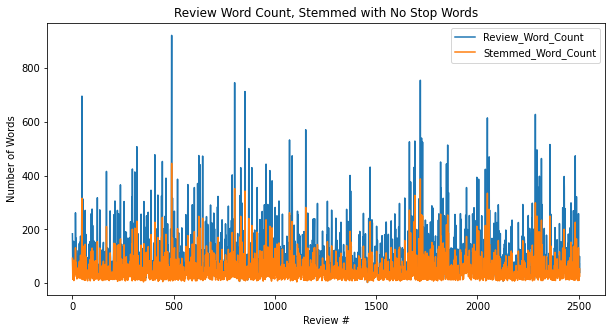

In [159]:
plt.figure(figsize=(10,5))
Vegas_restaurants_reviews_2017_2016[Vegas_restaurants_reviews_2017_2016['Review_Word_Count']< 2000]['Review_Word_Count'].plot()
Vegas_restaurants_reviews_2017_2016[Vegas_restaurants_reviews_2017_2016['Stemmed_Word_Count']< 1000]['Stemmed_Word_Count'].plot()
plt.title('Review Word Count, Stemmed with No Stop Words')
plt.xlabel('Review #')
plt.ylabel('Number of Words')
plt.legend()

Stemming makes a significant impact when it comes to total word count, especially on those longer reviews

# **Positive Opinion Lexicon**

Thanks to [https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt](https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt), we're able to create a positive opinion lexicon based on words commonly associated with positive sentiment. This list includes the words you would expect like 'good', 'great' and so on, but also common misspellings and phrases on social media. Using this lexicon we can count how many words within a review are also in the lexicon - this should give us an idea of which reviews are the most positive



In [160]:
file = open("positive_lexicon.txt", "r")
content = file.read()
pos_lex = content.splitlines()
pos_lex_stem = [snowBallStemmer.stem(word) for word in pos_lex]

In [161]:
good_count = []
for i in range(len(Vegas_restaurants_reviews_2017_2016)):
    count = 0
    tokens = Vegas_restaurants_reviews_2017_2016['Stemmed:Tokens'][i]
    for word in tokens:
        if word in pos_lex_stem:
            count += 1
    good_count.append(count)

In [162]:
Vegas_restaurants_reviews_2017_2016['Positive_Word_Count'] = good_count

In [163]:
Vegas_restaurants_reviews_2017_2016['Positive_Words_%'] = Vegas_restaurants_reviews_2017_2016['Positive_Word_Count']/(Vegas_restaurants_reviews_2017_2016['Review_Word_Count']-Vegas_restaurants_reviews_2017_2016['Stop_Word_Count'])

Text(0, 0.5, 'Percentage')

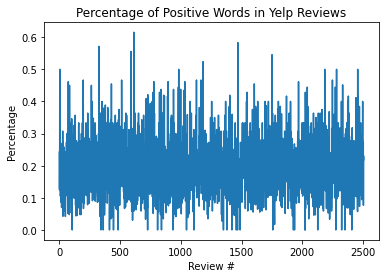

In [164]:
Vegas_restaurants_reviews_2017_2016['Positive_Words_%'].plot()
plt.title('Percentage of Positive Words in Yelp Reviews')
plt.xlabel('Review #')
plt.ylabel('Percentage')

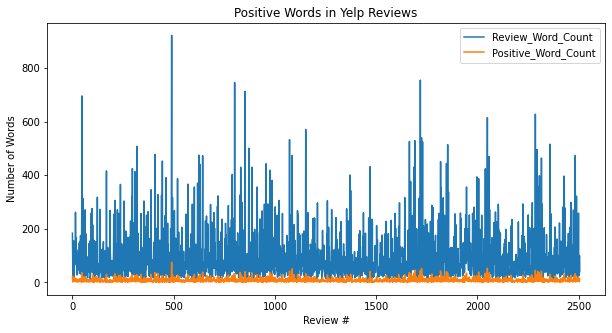

In [165]:
plt.figure(figsize=(10,5))
Vegas_restaurants_reviews_2017_2016[Vegas_restaurants_reviews_2017_2016['Review_Word_Count']< 2000]['Review_Word_Count'].plot()
Vegas_restaurants_reviews_2017_2016[Vegas_restaurants_reviews_2017_2016['Positive_Word_Count']< 600]['Positive_Word_Count'].plot()
plt.title('Positive Words in Yelp Reviews')
plt.xlabel('Review #')
plt.ylabel('Number of Words')
plt.legend()

**Polarity and Subjectivity**

TextBlob has a very useful library that can determine the Polarity(-1,1) and Subjectivity(0,1) from text. For this project, the polarity is really the only useful one, as it will help us classify the reviews we're working with now and help train for the model, but subjectiveness could be interesting to look into as well





In [42]:


In [166]:
from textblob import TextBlob

In [167]:
Vegas_restaurants_reviews_2017_2016['Polarity'] = Vegas_restaurants_reviews_2017_2016['Lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
Vegas_restaurants_reviews_2017_2016['Subjectivity'] = Vegas_restaurants_reviews_2017_2016['Lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])

**Polarity and Positive Word Percentage**

Let's see if there is a relationship between the percentage of positive words in a review and its polarity. I'll be doing this by soring the data into three sets:

1. Polarity < 0: Meaning these reviews should be negative and, therofore have a lower positive words percentage
2. Polarity > 0: Where the percentage of positive words SHOULD go up
3. Polarity = 0: Where the sentiment should be neutral, so the percentage should be in between the other






In [168]:
df1 = Vegas_restaurants_reviews_2017_2016[Vegas_restaurants_reviews_2017_2016['Polarity'] < 0]
df2 = Vegas_restaurants_reviews_2017_2016[Vegas_restaurants_reviews_2017_2016['Polarity'] > 0]
df3 = Vegas_restaurants_reviews_2017_2016[Vegas_restaurants_reviews_2017_2016['Polarity'] == 0]

df1 = df1.sort_values(by='Polarity')
df2 = df2.sort_values(by='Polarity')
df3 = df3.sort_values(by='Polarity')

df1 = df1.reset_index()
df2 = df2.reset_index()
df3 = df3.reset_index()

df3.index=np.arange(len(df1),(len(df1)+len(df3)))
df2.index=np.arange((len(df3)+len(df1)),(len(df1)+len(df3)+len(df2)))

In [169]:
df4 = Vegas_restaurants_reviews_2017_2016
df4 = df4.sort_values(by='Polarity')

Text(0, 0.5, 'Positive Word Percentage')

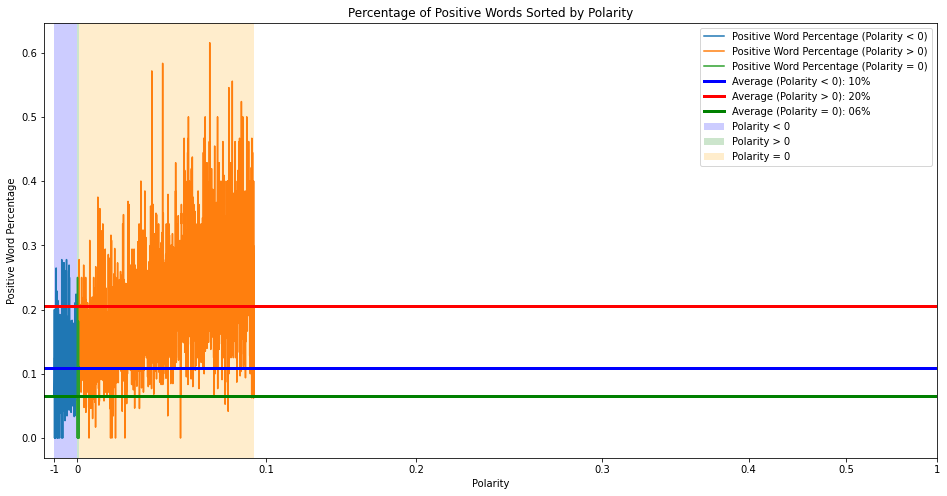

In [170]:
import matplotlib.transforms as transforms


# set up figure
fig, ax = plt.subplots(figsize=(16,8))

x = Vegas_restaurants_reviews_2017_2016.index

# set x axis for partial plots
x1 = df1.index
y1 = df1['Positive_Words_%']
x2 = df2.index
y2 = df2['Positive_Words_%']
x3 = df3.index
y3 = df3['Positive_Words_%']

# calculate average for each partial
av1 = df1['Positive_Words_%'].mean()
av2 = df2['Positive_Words_%'].mean()
av3 = df3['Positive_Words_%'].mean()

# plot word percentage
plt.plot(x1,y1,label='Positive Word Percentage (Polarity < 0)')
plt.plot(x2,y2,label='Positive Word Percentage (Polarity > 0)')
plt.plot(x3,y3,label='Positive Word Percentage (Polarity = 0)')

# plot area to define polarity zones
plt.axvspan(0,len(df1), facecolor='blue', alpha=0.2,label='Polarity < 0')
plt.axvspan(len(df1),(len(df1)+len(df3)), facecolor='green',alpha=0.2,label='Polarity > 0')
plt.axvspan((len(df1)+len(df3)),(len(df1)+len(df3)+len(df2)), facecolor='orange',alpha=0.2, label='Polarity = 0')

# plot average lines
plt.axhline(y=av1,linewidth=3, color='b',label='Average (Polarity < 0): '+str(av1)[2:4]+'%')
plt.axhline(y=av2,linewidth=3, color='r',label='Average (Polarity > 0): '+str(av2)[2:4]+'%')
plt.axhline(y=av3,linewidth=3, color='g',label='Average (Polarity = 0): '+str(av3)[2:4]+'%')

# label x axis as polarity
labels = ['-1','0','0.1','0.2','0.3','0.4','0.5','1']
ticks = [0,len(df1),2655,4539,6869,8704,9924,11065]

ax.set_xticks(ticks)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1, 1))
plt.title('Percentage of Positive Words Sorted by Polarity')
plt.xlabel('Polarity')
plt.ylabel('Positive Word Percentage')

Now as you can see by this plot, there's a significant increase in 'Positive Words Percentage' As the Polarity goes up - so does the percentage of positive words. This seems like it could be very useful when it comes to classifying reviews with our model later on.

# **Conclusion**

We now have a much better understanding of our data and have several metrics to use while working with these reviews. We know the total number of words, how many of those words are stop words, how many of those words are positive words and how we can use that information, along with polarity to classify the reviews into sentiments.



In [111]:
Vegas_restaurants_reviews_2017_2016.columns

Index(['business_id', 'name', 'city', 'state', 'postal_code', 'latitude',
       'longitude', 'restaurant_rating', 'review_id', 'user_id', 'stars',
       'date', 'text', 'useful', 'funny', 'cool', 'year', 'Review_Word_Count',
       'Review_Char_Count', 'Lowercase', 'Cleaned', 'No_Stop_Words:Tokens',
       'No_Stop_Words:Sentence', 'Stop_Word_Count', 'Stop_Words_%',
       'Lemmatized', 'Stemmed:Sentence', 'Stemmed:Tokens',
       'Stemmed_Word_Count', 'Polarity', 'Subjectivity', 'Positive_Word_Count',
       'Positive_Words_%'],
      dtype='object')

In [173]:
#only keeping columns that will be useful
Vegas_restaurants_reviews_2017_2016 = Vegas_restaurants_reviews_2017_2016[['business_id','name', 'stars', 'city', 'state', 'postal_code',
       'text', 'Review_Word_Count', 'No_Stop_Words:Tokens', 'No_Stop_Words:Sentence',
       'Stop_Word_Count', 'Stop_Words_%', 'Lemmatized', 'Stemmed:Sentence',
       'Stemmed:Tokens', 'Polarity','Positive_Word_Count', 'Positive_Words_%','Stemmed_Word_Count']]

In [178]:
Vegas_restaurants_reviews_2017_2016.to_csv(r'Vegas_restaurants_reviews_2017_2016.csv',index=False)